# Turing version


Goal is to make this match the sunode version and test. So far this is just copied from https://turinglang.org/v0.30/tutorials/10-bayesian-differential-equations/

As in the sunode version, we will use both pred and prey observations

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

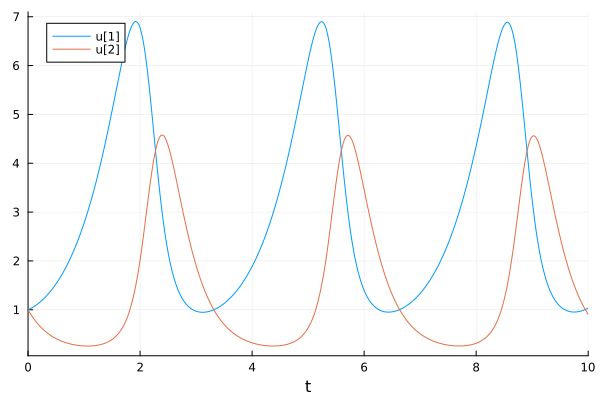

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [1.5, 1.0, 3.0, 1.0]
tspan = (0.0, 10.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)

# Plot simulation.
plot(solve(prob, Tsit5()))

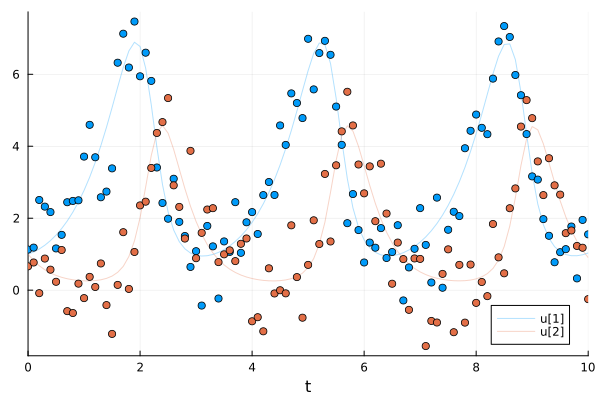

In [3]:
sol = solve(prob, Tsit5(); saveat=0.1)
odedata = Array(sol) + 0.8 * randn(size(Array(sol)))

# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(sol.t, odedata'; color=[1 2], label="")

In [5]:
odedata

2×101 Matrix{Float64}:
 1.12882   1.18263    2.50654    2.32217  …  0.32684  1.95252   1.55129
 0.662187  0.768939  -0.0831447  0.87828     1.22861  1.17954  -0.249514

In [6]:
@model function fitlv(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(0,10);lower = 0)
    y0 ~ truncated(Normal(0,10);lower = 0)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5); lower=0.5, upper=2.5)
    β ~ truncated(Normal(1.2, 0.5); lower=0, upper=2)
    γ ~ truncated(Normal(3.0, 0.5); lower=1, upper=4)
    δ ~ truncated(Normal(1.0, 0.5); lower=0, upper=2)

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob, Tsit5(); u0=u0, p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

model = fitlv(odedata, prob)

# Sample 3 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/ronaldlegere/.julia/packages/SciMLBase/cL99i/src/integrator_interface.jl:570
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


Chains MCMC chain (1000×19×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 52.94 seconds
Compute duration  = 52.46 seconds
parameters        = x0, y0, σ, α, β, γ, δ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          x0    1.4632    0.6470    0.2599     9.5527    71.0904    1.6633     ⋯
          y0    0.6326    0.4412    0.1766     9.5772    77.5408    1.6642     ⋯
           σ    1.1051    0.4654    0.1887     9.5234    67.4204    1.6625     ⋯
           α    1.1374    0.4298    0.1731     9.6501   120.7248    1.6627     ⋯
           β    0.9157    0.1462    0.0492    11.24

In [7]:
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)

Chains MCMC chain (300×6×1 Array{Float64, 3}):

Iterations        = 1:300
Number of chains  = 1
Samples per chain = 300
Wall duration     = 52.94 seconds
Compute duration  = 52.46 seconds
parameters        = x0, y0, α, β, γ, δ
internals         = 

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          x0    1.4589    0.6452    0.0373   269.5582   260.0969    0.9982     ⋯
          y0    0.6278    0.4430    0.0251   290.8862   253.8984    1.0029     ⋯
           α    1.1370    0.4305    0.0242   312.5609   258.5762    0.9973     ⋯
           β    0.9234    0.1416    0.0082   318.4637   254.0321    0.9970     ⋯
           γ    3.0931    0.3054    0.0183   277.7094   287.5241    1.0012     ⋯
           δ    1.1359    0.1330    0.0075   331.1350   332.7924    1.0045     ⋯
                                                                1 column omitted

Q

In [13]:
Array(posterior_samples)[1,:][3:end]

4-element Vector{Float64}:
 1.563827958383218
 1.1433590059367646
 2.9968512096336744
 1.048854693156315

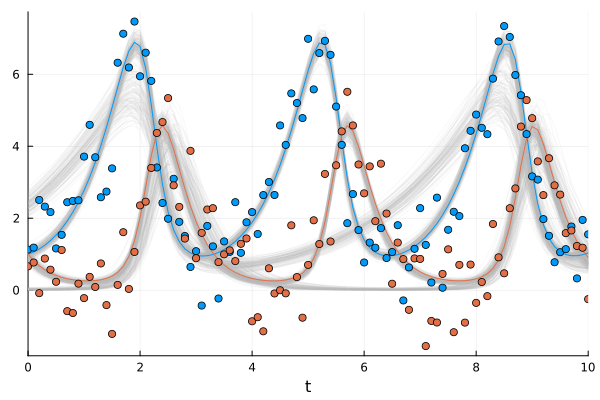

In [15]:
plot(; legend=false)
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)
for row in eachrow(Array(posterior_samples))
    u0 = row[1:2]
    p = row[3:end]
    sol_p = solve(prob, Tsit5();u0=u0, p=p, saveat=0.1)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
plot!(sol; color=[1 2], linewidth=1)
scatter!(sol.t, odedata'; color=[1 2])